In [1]:
#Import Modules
import pyart
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from io import StringIO
from boto.s3.connection import S3Connection
import shutil, os, sys
import gzip
import pylab as plb
import matplotlib as mpl
import numpy.ma as ma
import netCDF4
from pylab import *
print(pyart.__version__)

1.6.0


/home/zsherman/anaconda3/lib/python3.5/site-packages/pyart/map/grid_mapper.py:40: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  from .ball_tree import BallTree
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1=

In [2]:
conn = S3Connection(anon=True)
bucket = conn.get_bucket('testradar')
for key in bucket.list():
    print (key.name.encode('utf-8'))
#CPOL (C-band Polarimetric Radar)

b'CSU_unfolded/'
b'CSU_unfolded/CPOL_corr_20060122_140009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_141010_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_142009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_143009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_144009_vt_unfolded_hand.cfrad.nc.gz'
b'CSU_unfolded/CPOL_corr_20060122_145009_vt_unfolded_hand.cfrad.nc.gz'
b'zindex.png'


In [3]:
#gzip and opening CPOL files
LOCAL_PATH = '/home/zsherman/Documents/Jupyter/'
filenames = []
bucket_list = bucket.list()
for l in bucket_list:
    keyString = str(l.key)
    print(keyString)
    if '.gz' in keyString:
        l.get_contents_to_filename(LOCAL_PATH+keyString)
        filenames.append(LOCAL_PATH+keyString[0:-3])
        gzfh = gzip.open(LOCAL_PATH+keyString, 'rb')
        ofh = open(LOCAL_PATH+keyString[0:-3], 'wb')
        for line in gzfh:
            ofh.write(line)
        ofh.close()
        gzfh.close()
        os.remove(LOCAL_PATH+keyString)

CSU_unfolded/
CSU_unfolded/CPOL_corr_20060122_140009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_141010_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_142009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_143009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_144009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_145009_vt_unfolded_hand.cfrad.nc.gz
zindex.png


In [4]:
radar_files = []
for filename in filenames:
    radar_files += [pyart.io.read(filename)]

In [5]:
#Defining and running all files through the pyart dealias algorithm
def corrected_velocity_added(radar):
        corrV_added = pyart.correct.dealias_region_based(radar, interval_splits=10, rays_wrap_around=True, keep_original=False)
        radar.add_field('corrected_velocity_added', corrV_added, replace_existing = True)

In [6]:
#Defining and displaying reflectivity field for all files.
def reflectivity_fields(radar):
    dZ = radar.fields['reflectivity']['data']
    dZ_mean = ma.mean(dZ)
    dZ_std = ma.std(dZ)
    dZ_max = ma.max(dZ)
    indxs = ma.where(dZ == ma.max(dZ))

    print('Statistics of reflectivity field: %.0f' % (dZ_mean) + " +/- " + '%.0f' % (dZ_std))

In [7]:
#Displaying Velocity from all files.
def velocity_data(radar):
    velocity = [ma.asanyarray(radar.fields['velocity']['data'])]
    print("Velocity")
    return velocity

In [8]:
def corrected_velocity_data(radar):
    cv_attribute_name = ''
    if ('corrected_velocity' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity'
    elif ('corrected_velocity2' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity2'
    else:
        raise Exception('key not found')
    corrected_velocity = ma.asanyarray(radar.fields[cv_attribute_name]['data'])
    print("Corrected Velocity")
    return corrected_velocity

In [9]:
#Finding the dealiased difference from the changes done by pyart.
def dealiasing_differences_func_region(radar, ny_vel):
    diff_reg = radar.fields['corrected_velocity_added']['data'] - radar.fields['velocity']['data']
    diff_reg_sc = diff_reg/ny_vel
    diff_region = radar.fields['corrected_velocity_added']
    diff_region['data'] = diff_reg_sc
    diff_region['long_name'] = 'Region Dealiased Added Nyquist intervals'
    diff_region['standard_name'] = "region_added_Ny_intervals"
    diff_region['units']=''
    radar.add_field('dealiasing_differences_sc_region', diff_region, replace_existing = True)

In [10]:
#Finding the dealiased difference from the changes done by hand.
#There are two functions because radar_files[2] has a different name for corrected_velocity.
#Instead corrected_velocity2
def dealiasing_differences_func_hand(radar, ny_vel):
    cv_attribute_name = ''
    if ('corrected_velocity' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity'
    elif ('corrected_velocity2' in radar_file.fields):
        cv_attribute_name = 'corrected_velocity2'
    else:
        raise Exception('key not found')
    diff_ha = radar.fields[cv_attribute_name]['data'] - radar.fields['velocity']['data']
    diff_ha_sc = diff_ha/ny_vel
    diff_hand = radar.fields[cv_attribute_name]
    diff_hand['data'] = diff_ha_sc
    diff_hand['long_name'] = 'Hand Dealiased Added Nyquist intervals'
    diff_hand['standard_name'] = "hand_added_Ny_intervals"
    diff_hand['units']=''
    radar.add_field('dealiasing_differences_sc_hand', diff_hand, replace_existing = True)

def difference_hand_region(radar):
    diff_both = radar.fields['dealiasing_differences_sc_region']['data'] - radar.fields['dealiasing_differences_sc_hand']['data'])
    diff_both['data'] = diff_both
    diff_both['long_name'] = 'Difference Between Added Nyquist intervals'
    diff_both['standard_name'] = "difference_added_Ny_intervals"
    diff_both['units']=''
    radar.add_field('difference_hand_region', diff_both, replace_existing = True)

In [11]:
#Number of hand-dealiased gates that occured.
def n_gates_hand_func(radar):
    dealias_hands = []
    dealias_hand = ma.asanyarray(radar.fields['dealiasing_differences_sc_hand']['data'][radar.get_slice(3)])
    dealias_hands += [dealias_hand]
    n_gates_hands = []
    n_gates_hand = (np.count_nonzero(dealias_hand != 0))
    n_gates_hands +=[n_gates_hand]
    print("Number of Gates Hand Dealiased")
    return n_gates_hand

In [12]:
#Number of region-dealiased gates that occur.
def n_gates_region_func(radar):
    dealias_regions = []
    dealias_region = ma.asanyarray(radar.fields['dealiasing_differences_sc_region']['data'][radar.get_slice(3)])
    dealias_regions += [dealias_region]
    n_gates_regions = []
    n_gates_region = (np.count_nonzero(dealias_region != 0))
    n_gates_regions +=[n_gates_region]
    print("Number of Gates Region Dealiased")
    return n_gates_region

Number of Gates Hand Dealiased
1926
Number of Gates Region Dealiased
1929


/home/zsherman/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/zsherman/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


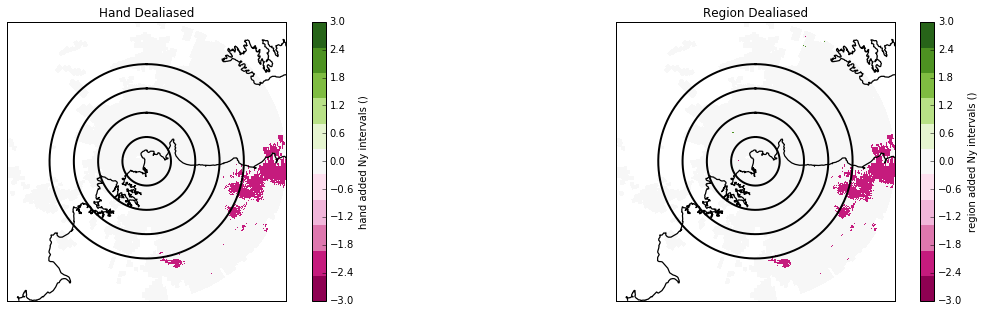

Number of Gates Hand Dealiased
1771
Number of Gates Region Dealiased
1782


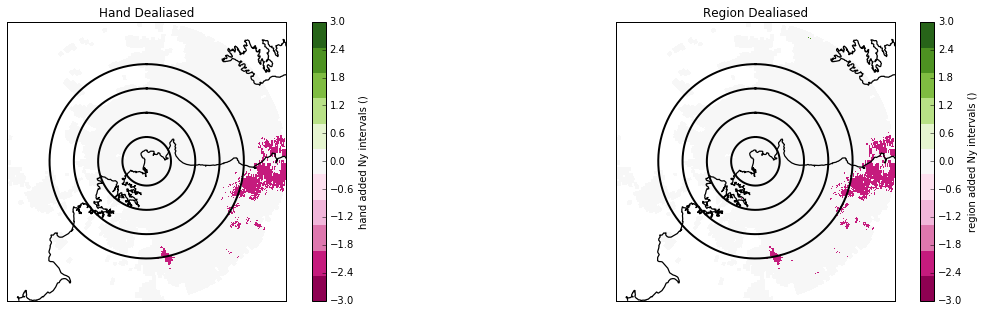

Number of Gates Hand Dealiased
40350
Number of Gates Region Dealiased
2102


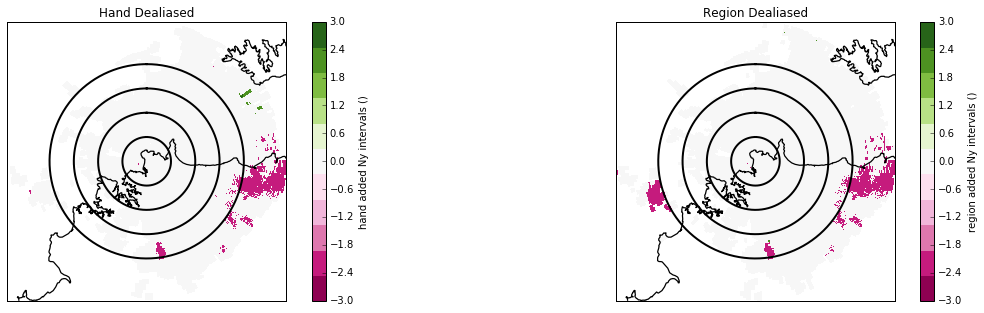

Number of Gates Hand Dealiased
1789
Number of Gates Region Dealiased
1846


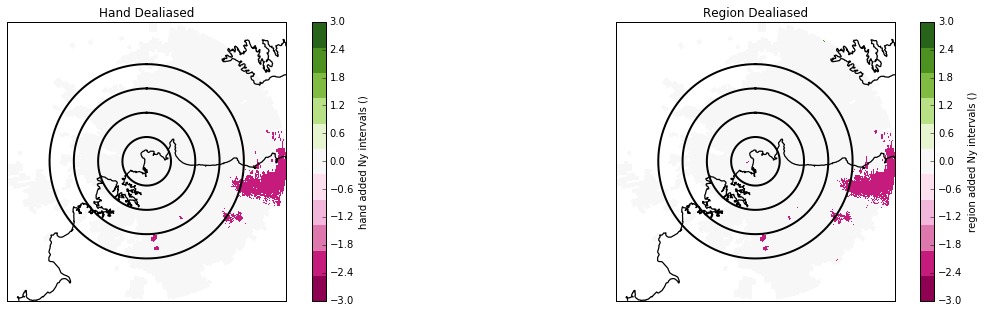

Number of Gates Hand Dealiased
2103
Number of Gates Region Dealiased
2123


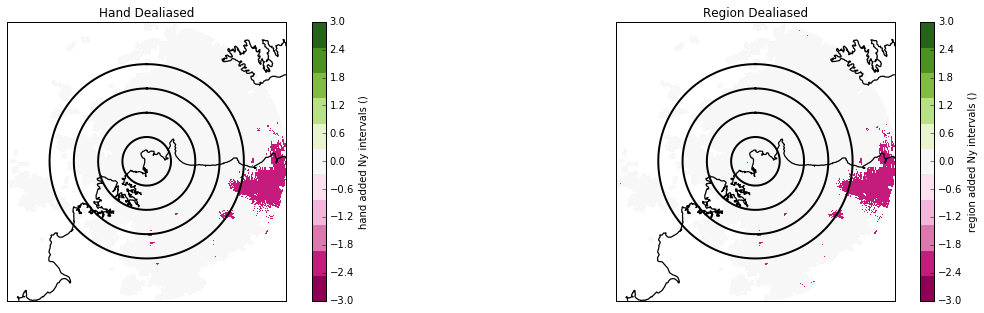

Number of Gates Hand Dealiased
1943
Number of Gates Region Dealiased
1976


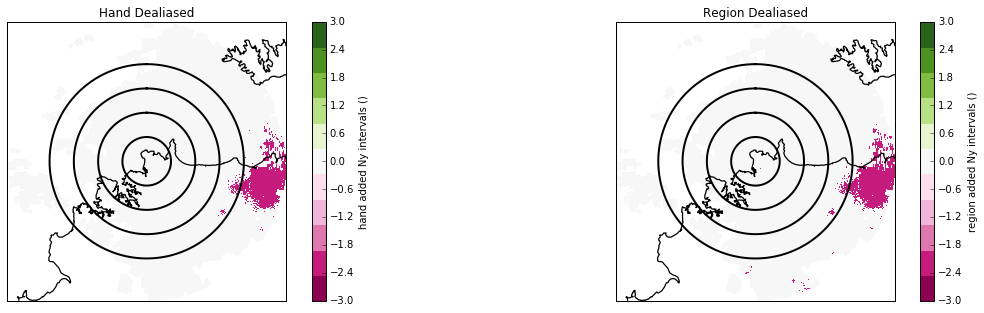

In [14]:
#Plotting region-dealiased radar difference
#Saving radar images in order to later convert into gifs
for radar_file in radar_files:   
    corrected_velocity_added(radar_file)
    ny_vel = radar_file.instrument_parameters['nyquist_velocity']['data'][0]
    dealiasing_differences_func_region(radar_file, ny_vel)
    #Putting each radar_file through the dealiasing difference function.
    dealiasing_differences_func_hand(radar_file, ny_vel)
    #difference_hand_region(radar_file)
    print(n_gates_hand_func(radar_file))
    print(n_gates_region_func(radar_file))
    out_path_1 = '/home/zsherman/Documents/Jupyter/CSU_unfolded/Images/Region_Dealiased_Differences/'
    out_path_2 = '/home/zsherman/Documents/Jupyter/CSU_unfolded/Images/Hand_Dealiased_Differences/'

    d_cmap = cm.get_cmap('PiYG', 11)
    sw_sel = 0
    sw_num = radar_file.nsweeps
    sw_elevs = [radar_file.fixed_angle['data'][sw] for sw in range(0, sw_num-1)]
    el_sel = sw_elevs[sw_sel]


    display = pyart.graph.RadarMapDisplay(radar_file)
    fig = plt.figure(figsize=(20, 35), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(622)
    display.plot_ppi_map('dealiasing_differences_sc_region', sweep= 3, vmin=-3, vmax=3, ax=ax, title='Region Dealiased', mask_outside=False, cmap=d_cmap)
    display.plot_range_rings(range(25, 125, 25))
    display.plot_cross_hair(0.5)
    out_file_1 = out_path_1 + os.path.basename(filename).split('.', 1)[0]+ '_el%.0f' % (el_sel) + '_region_changes.png'
    plt.savefig(out_file_1, bbox_inches='tight')

    display = pyart.graph.RadarMapDisplay(radar_file)
    ax = fig.add_subplot(621)
    display.plot_ppi_map('dealiasing_differences_sc_hand', sweep= 3, vmin=-3, vmax=3, ax=ax, title='Hand Dealiased', mask_outside=False, cmap=d_cmap)
    display.plot_range_rings(range(25, 125, 25))
    display.plot_cross_hair(0.5)
    out_file_2 = out_path_2 + os.path.basename(filename).split('.', 1)[0]+ '_el%.0f' % (el_sel) + '_hand_changes.png'
    plt.savefig(out_file_2, bbox_inches='tight')

    #display = pyart.graph.RadarMapDisplay(radar_file)
    #ax = fig.add_subplot(633)
    #display.plot_ppi_map(diff_both, sweep= 3, vmin=-3, vmax=3, ax=ax, title='Difference Between Hand and Region Dealias', mask_outside=False, cmap=d_cmap)
    #display.plot_range_rings(range(25, 125, 25))
    #display.plot_cross_hair(0.5)


    plt.show()

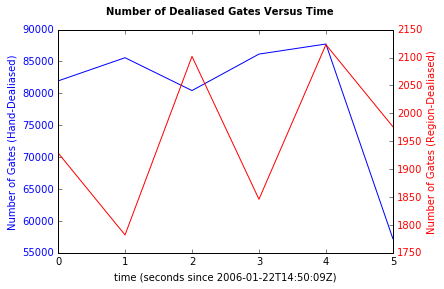

In [79]:
dealias_regions = []
n_gates_regions = []
dealias_hands = []
n_gates_hands = []
times = []
for radar_file in radar_files:
    dealias_hand = ma.asanyarray(radar_file.fields['dealiasing_differences_sc_hand']['data'][radar_file.get_slice(3)])
    dealias_hands += [dealias_hand]
    n_gates_hand = (np.count_nonzero(dealias_hand != 0))
    dealias_region = ma.asanyarray(radar_file.fields['dealiasing_differences_sc_region']['data'][radar_file.get_slice(3)])
    dealias_regions += [dealias_region]
    n_gates_region = (np.count_nonzero(dealias_region != 0))
    n_gates_regions +=[n_gates_region]
    n_gates_hands +=[n_gates_hand]
    time = np.array(radar_file.time)
    times += [time]
    dealias_hands += [dealias_hand]
fig, ax1 = plt.subplots()
fig.suptitle('Number of Dealiased Gates Versus Time', fontsize=10, fontweight='bold')
y1 = n_gates_hands
ax1.plot(y1, 'b-')
ax1.set_xlabel(radar_file.time['standard_name'] + ' (' + radar_file.time['units'] + ')')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Number of Gates (Hand-Dealiased)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim()
x = times
plt.xlim()
ax2 = ax1.twinx()
y2 = n_gates_regions
ax2.plot(y2, 'r-')
ax2.set_ylabel('Number of Gates (Region-Dealiased)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.ylim()
plt.show()

#Plot gates and time


NameError: name 'n_gates_hands' is not defined

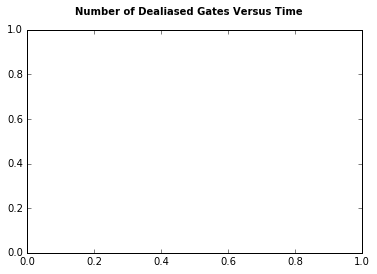

In [16]:
    fig, ax1 = plt.subplots()
    fig.suptitle('Number of Dealiased Gates Versus Time', fontsize=10, fontweight='bold')
    y1 = n_gates_hands[0:]
    ax1.plot(y1, 'b-')
    ax1.set_xlabel(radar.time['standard_name'] + ' (' + radar.time['units'] + ')')
    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel('Number of Gates (Hand-Dealiased)', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    plt.ylim()
    x = time
    plt.xlim()
    ax2 = ax1.twinx()
    y2 = n_gates_regions[0:]
    ax2.plot(y2, 'r-')
    ax2.set_ylabel('Number of Gates (Region-Dealiased)', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.ylim()
    plt.show()

#Plot gates and time
fig, ax1 = plt.subplots()
fig.suptitle('Number of Dealiased Gates Versus Time', fontsize=10, fontweight='bold')
y1 = n_gates_hand
ax1.plot(y1, 'b-')
ax1.set_xlabel('Time')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Number of Gates (Hand-Dealiased)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim()
x = time

ax2 = ax1.twinx()
y2 = n_gates_region
ax2.plot(y2, 'r-')
ax2.set_ylabel('Number of Gates (Region-Dealiased)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.ylim()
plt.show()